In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import csv

## One-dimensional Doppler cooling

Let's try to use a quantum Monte Carlo calculation to simulate Doppler cooling in one dimension. We'll lean heavily on Section 5F in this paper by Mølmer, Castin, and Dalibard (<https://www.osapublishing.org/josab/abstract.cfm?URI=josab-10-3-524>).

They assume a two internal levels, $|g, m_g = J_g\rangle$ and $|e, m_e = J_e + 1\rangle$ that are coupled by a standing wave of $\sigma^+$ light, and use the following Hamiltonian:
$$H = \frac{\hat{p}^2}{2m} + \hbar \Omega\cos(k \hat{x}) \left( |g\rangle\langle e| + |e\rangle\langle g| \right) - \hbar\delta|e\rangle\langle e|.$$

For some reason they drop the $\cos(k \hat{x})$, perhaps because it's assumed to average out to some value? Either way, following the example we set up a momentum basis and a two-level system.

First we define the simulation aprameters, and construct an initial state in the basis $\left\{ |g\rangle, |e\rangle \right\}\otimes \left\{ |p = -n_\mathrm{max}\hbar k\rangle \cdots |p = n_\mathrm{max}\hbar k \right\}$ such that $|\psi(t = 0)\rangle = |g, p = 0 \rangle$

In [2]:
nmax = 50

mRb = 3.8175409E-26 #actually Na-23 mass, somewhat confusing.
hbar = 1.05457E-34
hbarOvermRb = hbar/mRb     #This is needed for some precision problem

k = 2*np.pi/589E-9
Gamma = 200*hbar*k**2/mRb #2*np.pi * 6.065E6
Omega = Gamma/2
delta = -Gamma/2

psi0 = tensor(basis(2,0), basis(2*nmax + 1, nmax))

Next we set up the Hamiltonian matrices. We have to take care that all the momentum couplings are accounted for. We want the processes:
$$
|g, 2n\hbar k \rangle \rightarrow |e, (2n + 1)\hbar k \rangle \\
|g, 2n\hbar k \rangle \rightarrow |e, (2n - 1)\hbar k \rangle \\
|e, (2n + 1)\hbar k \rangle \rightarrow |g, 2(n + 1)\hbar k \rangle \\
|e, (2n + 1)\hbar k \rangle \rightarrow |g, 2n\hbar k \rangle.
$$
In the QuTiP framework we can use a `tunneling(N, M)` matrix with `M = 1` for the momentum part (this basically describes nearest-neighbor tunneling in some basis). The internal state coupling is simply described by a $\sigma_x$ matrix.

In [3]:
coupling = tensor(sigmax(), tunneling(2*nmax + 1, 1))

We also need to set up a momentum operator. This can simply be done using the `charge(N)` matrix from QuTiP. This leaves the internal state of the atom unaffected, so for that we simply use `qeye(2)`.

In [4]:
momentum = tensor(qeye(2), charge(nmax))

For the last term in $H$ we need an operator in $|e\rangle\langle e|$, again we use `qeye()` to take the unaffected part of the basis along.

In [5]:
Pe = tensor(basis(2, 1).proj(), qeye(2*nmax + 1))

The Hamiltonian is good to go, we just need the dephasing now. This is a jump operator $\sqrt{\Gamma}|g\rangle\langle e|$, but following Mølmer _et al._ we need to assign different scattering directions different probabilities. Specifically, they set the probability for $C_{\pm k}$ to 1/5, and that for $C_{0}$ to 3/5.

In [6]:
decay = Qobj([[0, 1], [0, 0]])
C0 = np.sqrt(3/5 * Gamma) * tensor(decay, qeye(2*nmax + 1))
Cmk = np.sqrt(1/5 * Gamma) * tensor(decay, qdiags(np.ones(2*nmax), 1))
Cpk = np.sqrt(1/5 * Gamma) * tensor(decay, qdiags(np.ones(2*nmax), -1))

Cs = [C0, Cmk, Cpk]

In [7]:
H = hbarOvermRb*(k*momentum)**2/2 + Omega/2 * coupling - delta * Pe

We define the squared momentum as the observable.

In [8]:
timeax = np.linspace(0, 2000, 5000)/Gamma
result = mcsolve(H, psi0, timeax, e_ops = momentum**2, c_ops = Cs, ntraj = 1000)

10.0%. Run time:  38.47s. Est. time left: 00:00:05:46
20.0%. Run time:  72.79s. Est. time left: 00:00:04:51
30.0%. Run time: 107.92s. Est. time left: 00:00:04:11
40.0%. Run time: 143.16s. Est. time left: 00:00:03:34
50.0%. Run time: 178.38s. Est. time left: 00:00:02:58
60.0%. Run time: 213.18s. Est. time left: 00:00:02:22
70.0%. Run time: 247.72s. Est. time left: 00:00:01:46
80.0%. Run time: 282.74s. Est. time left: 00:00:01:10
90.0%. Run time: 318.10s. Est. time left: 00:00:00:35
100.0%. Run time: 352.44s. Est. time left: 00:00:00:00
Total run time: 352.61s


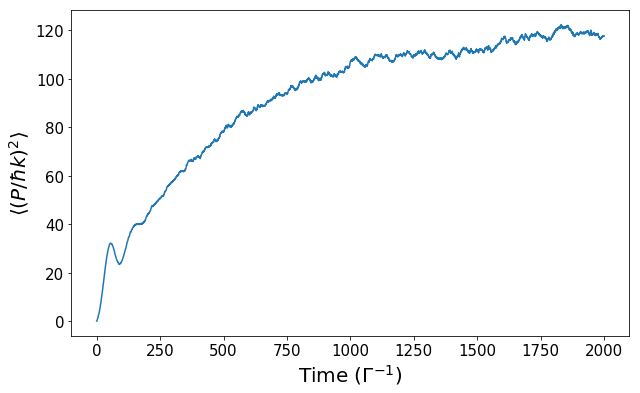

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(timeax*Gamma, result.expect[0])
    
ax.set_xlabel(r'Time ($\Gamma^{-1}$)', size = 20)
ax.set_ylabel(r'$\langle (P/\hbar k)^2\rangle$', size = 20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

This is equivalent to the Monte Carlo data in Fig. 2 by Mølmer _et al._ Let's save it.

In [10]:
exportdata = np.transpose([timeax*Gamma, result.expect[0]])
with open('qmc_1d_doppler.csv', 'w', newline = '') as file:
    writer = csv.writer(file, delimiter = ',')
    for row in exportdata:
        writer.writerow(row)